- feature: pclass, sex, fare
- label: survived

1. 1등급, female, 32달러 인경우 생사유무를 예측하시요
( voting , bagging, boost, deep learning 을 이용하시요) 
2. 위의 모델의 train, test, f1 score 를 구하시요
3. confusion matrix 를 구하고 heatmap 을 그리시요.
4. roc curve 를 그리시요.

##  라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_curve, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.simplefilter('ignore')

In [2]:
titanic = sns.load_dataset('titanic')
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


### 데이터 분리

In [3]:
x_data, y_data = titanic[['pclass', 'sex', 'fare']], titanic['survived']

In [4]:
x_data.isnull().sum()

pclass    0
sex       0
fare      0
dtype: int64

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, 
                                                    random_state=1, stratify=y_data)

### 예측할 데이터

In [6]:
xd = pd.DataFrame([[1, 'female', 32.0]], columns=x_data.columns)
xd

,pclass,sex,fare
0,1,female,32.0


## voting

### 모델 생성 및 학습

In [7]:
ct = make_column_transformer((OneHotEncoder(), ['pclass', 'sex']), (StandardScaler(), ['fare']))

model_logi = LogisticRegression()
model_knn = KNeighborsClassifier()
model_tree = DecisionTreeClassifier()
model_forest = RandomForestClassifier()


model_vote = VotingClassifier(estimators=[('logi', model_logi), ('knn', model_knn), ('tree', model_tree),('forest', model_forest)], 
                              voting='soft' )
pipe = make_pipeline(ct, model_vote)

pipe.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['pclass', 'sex']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['fare'])])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('logi', LogisticRegression()),
                                              ('knn', KNeighborsClassifier()),
                                              ('tree',
                                               DecisionTreeClassifier()),
                                              ('forest',
                                               RandomForestClassifier())],
                                  voting='soft'))])

### 생사유무 예측

In [8]:
pipe.predict(xd)

array([1], dtype=int64)

### train, test f1-score

In [9]:
y_train_pred = pipe.predict(x_train)
y_test_pred = pipe.predict(x_test)

print('(train) f1-socre :', f1_score(y_train, y_train_pred))
print('(test) f1-socre : ', f1_score(y_test, y_test_pred))

(train) f1-socre : 0.8688845401174168
(test) f1-socre :  0.7727272727272727


### confusion matrix


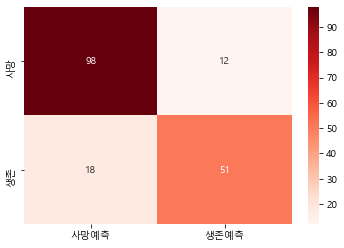

In [10]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, cmap='Reds', 
            xticklabels=['사망예측', '생존예측'],
            yticklabels=['사망', '생존'], fmt='d')
plt.show()

### roc curve

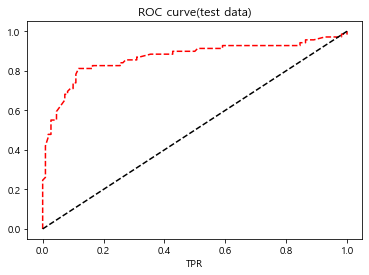

In [11]:
y_score = pipe.predict_proba(x_test)[:, 1]
fpr, tpr, thres = roc_curve(y_test, y_score)

plt.plot(fpr, tpr, 'r--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.xlabel('TPR')
plt.title('ROC curve(test data)')
plt.show()

## bagging

### 모델 생성 및 학습

In [12]:
ct = make_column_transformer((OneHotEncoder(), ['pclass', 'sex']), (StandardScaler(), ['fare']))
param_grid = {'baggingclassifier__base_estimator':[DecisionTreeClassifier(criterion='entropy'), LogisticRegression(), SVC()]}
pipe = make_pipeline(ct, BaggingClassifier())
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1')
grid.fit(x_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['pclass',
                                                                          'sex']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['fare'])])),
                                       ('baggingclassifier',
                                        BaggingClassifier())]),
             param_grid={'baggingclassifier__base_estimator': [DecisionTreeClassifier(criterion='entropy'),
                                                               Logistic

In [13]:
print(grid.best_params_)
print(grid.best_score_)

{'baggingclassifier__base_estimator': DecisionTreeClassifier(criterion='entropy')}
0.7296038925353817


### 생사유무 예측

In [14]:
grid.best_estimator_.predict(xd)

array([1], dtype=int64)

### train, test f1-score

In [15]:
y_train_pred = grid.best_estimator_.predict(x_train)
y_test_pred = grid.best_estimator_.predict(x_test)

print('(train) f1-socre :', f1_score(y_train, y_train_pred))
print('(test) f1-socre : ', f1_score(y_test, y_test_pred))

(train) f1-socre : 0.8773946360153256
(test) f1-socre :  0.7727272727272727


### confusion matrix

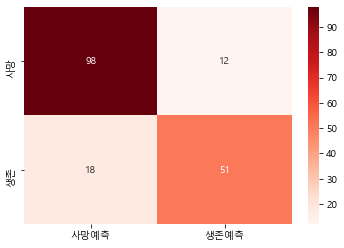

In [16]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, cmap='Reds', 
            xticklabels=['사망예측', '생존예측'],
            yticklabels=['사망', '생존'], fmt='d')
plt.show()

### roc curve

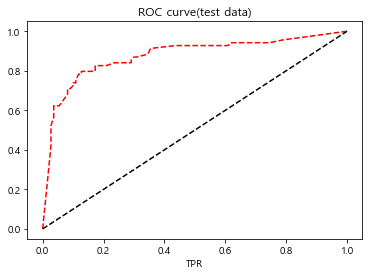

In [17]:
y_score = grid.best_estimator_.predict_proba(x_test)[:, 1]
fpr, tpr, thres = roc_curve(y_test, y_score)

plt.plot(fpr, tpr, 'r--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.xlabel('TPR')
plt.title('ROC curve(test data)')
plt.show()

## boost

### 모델 생성 및 학습

In [18]:
ct = make_column_transformer((OneHotEncoder(), ['pclass', 'sex']),(StandardScaler(), ['fare']))
param_grid = {'adaboostclassifier__base_estimator':[DecisionTreeClassifier(criterion='entropy'), LogisticRegression(), SVC()]}
pipe = make_pipeline(ct, AdaBoostClassifier())
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1')
grid.fit(x_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['pclass',
                                                                          'sex']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['fare'])])),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier())]),
             param_grid={'adaboostclassifier__base_estimator': [DecisionTreeClassifier(criterion='entropy'),
                                                                Logi

In [19]:
print(grid.best_params_)
print(grid.best_score_)

{'adaboostclassifier__base_estimator': DecisionTreeClassifier(criterion='entropy')}
0.7418765411889132


### 생사유무 예측

In [20]:
grid.best_estimator_.predict(xd)

array([1], dtype=int64)

### train, test f1-score

In [21]:
y_train_pred = grid.best_estimator_.predict(x_train)
y_test_pred = grid.best_estimator_.predict(x_test)

print('(train) f1-socre :', f1_score(y_train, y_train_pred))
print('(test) f1-socre : ', f1_score(y_test, y_test_pred))

(train) f1-socre : 0.8804554079696395
(test) f1-socre :  0.7761194029850746


### confusion matrix

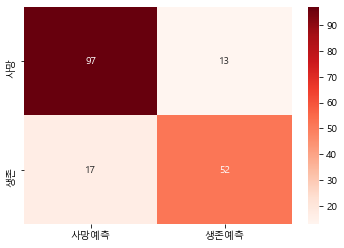

In [22]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, cmap='Reds', 
            xticklabels=['사망예측', '생존예측'],
            yticklabels=['사망', '생존'], fmt='d')
plt.show()

### roc curve

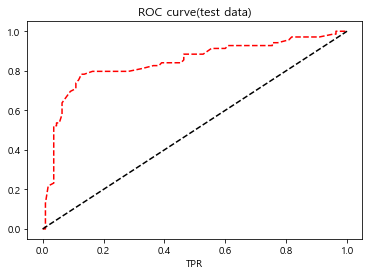

In [23]:
y_score = grid.best_estimator_.predict_proba(x_test)[:, 1]
fpr, tpr, thres = roc_curve(y_test, y_score)

plt.plot(fpr, tpr, 'r--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.xlabel('TPR')
plt.title('ROC curve(test data)')
plt.show()

## deep learning

### 모델 생성 및 학습

In [24]:
ct = make_column_transformer((OneHotEncoder(), ['pclass', 'sex']), 
                             (StandardScaler(), ['fare']))
pipe = make_pipeline(ct, MLPClassifier())
param_grid = {'mlpclassifier__hidden_layer_sizes':[(64, 32, 16),(64, 32, 16, 8),(64, 32, 16, 8, 4),(32, 16, 8, 4),(32, 16, 8, 4, 2), (128, 64, 32, 16, 8)], 
              'mlpclassifier__max_iter':[1000, 2000]}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=5)
grid.fit(x_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['pclass',
                                                                          'sex']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['fare'])])),
                                       ('mlpclassifier', MLPClassifier())]),
             param_grid={'mlpclassifier__hidden_layer_sizes': [(64, 32, 16),
                                                               (64, 32, 16, 8),
                                                               (64, 32

In [25]:
print(grid.best_params_)
print(grid.best_score_)

{'mlpclassifier__hidden_layer_sizes': (64, 32, 16, 8, 4), 'mlpclassifier__max_iter': 1000}
0.6915089104643601


### 생사유무 예측

In [26]:
grid.best_estimator_.predict(xd)

array([1], dtype=int64)

### train, test f1-score

In [27]:
y_train_pred = grid.best_estimator_.predict(x_train)
y_test_pred = grid.best_estimator_.predict(x_test)

print('(train) f1-socre :', f1_score(y_train, y_train_pred))
print('(test) f1-socre : ', f1_score(y_test, y_test_pred))

(train) f1-socre : 0.7137096774193549
(test) f1-socre :  0.75


### confusion matrix

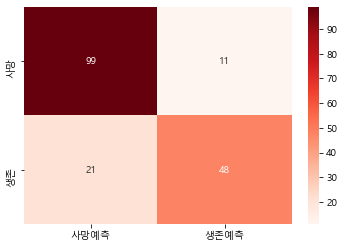

In [28]:
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, cmap='Reds', 
            xticklabels=['사망예측', '생존예측'],
            yticklabels=['사망', '생존'], fmt='d')
plt.show()

### roc curve

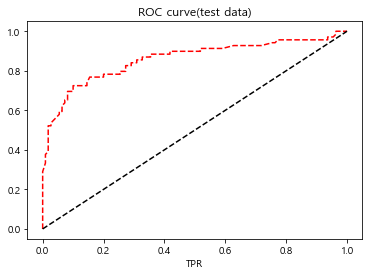

In [29]:
y_score = grid.best_estimator_.predict_proba(x_test)[:, 1]
fpr, tpr, thres = roc_curve(y_test, y_score)

plt.plot(fpr, tpr, 'r--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.xlabel('TPR')
plt.title('ROC curve(test data)')
plt.show()